In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from experiments.interpretation.interpretation_util import (
    ExperimentFiles,
    ExperimentFolders,
)


notebook_dir = os.path.abspath("")

file_path = os.path.abspath(
    os.path.join(
        notebook_dir,
        "..",
        "results",
        "experiments",
        ExperimentFolders.GEMINI_20_FLASH,
        ExperimentFiles.ALL_TOOLS_LOCAL,
    )
)


# Load JSON data (as list of dicts)
with open(file_path) as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Data preparation

In [2]:
# Helper function to count contained and total facts
def count_facts(fact_list):
    if not isinstance(fact_list, list):
        return 0, 0
    total = len(fact_list)
    contained = sum(f.get("is_contained", False) for f in fact_list)
    return contained, total


# Apply to dataframe
df["direct_facts_contained"], df["direct_facts_total"] = zip(
    *df["fact_score.direct_facts"].apply(count_facts)
)
df["supporting_facts_contained"], df["supporting_facts_total"] = zip(
    *df["fact_score.supporting_facts"].apply(count_facts)
)

import numpy as np

# Define conditions based on the 'id' prefix
conditions = [
    df["id"].str.startswith("EA"),
    df["id"].str.startswith("MS"),
    df["id"].str.startswith("PS"),
    df["id"].str.startswith("STC"),
]

# Corresponding labels
labels = [
    "Extensibility Assistance",
    "Malaysia Support",
    "Peppol Support",
    "Settlement Cases",
]

# Create the new column
df["case_type"] = np.select(conditions, labels, default="Unknown")

df = df.sort_values(by="id")

# Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 0 to 79
Data columns (total 37 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         91 non-null     object 
 1   question                                   91 non-null     object 
 2   answer                                     91 non-null     object 
 3   product                                    91 non-null     object 
 4   category                                   91 non-null     object 
 5   persona                                    91 non-null     object 
 6   activity                                   91 non-null     object 
 7   country                                    91 non-null     object 
 8   facts                                      91 non-null     object 
 9   bert_score                                 91 non-null     float64
 10  agent_judge_outcome              

In [4]:
df

,id,question,answer,product,category,persona,activity,country,facts,bert_score,...,agent_judge_tokens_consumed.output_tokens,agent_judge_tokens_consumed.total_tokens,tokens_consumed.input_tokens,tokens_consumed.output_tokens,tokens_consumed.total_tokens,direct_facts_contained,direct_facts_total,supporting_facts_contained,supporting_facts_total,case_type
0,EA-1,How can I attach additional files to standard ...,To attach additional files to the standard XML...,ERP (only SAP S/4HANA Cloud Public Edition),How to Develop (Maintenance - Customer case su...,Developer (Customer side),Custom Development,Cross,[{'fact': 'You can attach additional files to ...,0.206289,...,3,8208,3735,407,4142,1,3,3,5,Extensibility Assistance
7,EA-10,What BAdIs can be used to extend the Manage El...,The BAdIs EDOC_CUSTOM_FIELDS_CLOUD and EDOC_CU...,ERP (only SAP S/4HANA Cloud Public Edition),How to Develop (Maintenance - Customer case su...,Developer (Customer side),Custom Development,Cross,[{'fact': 'The BAdI EDOC_CUSTOM_FIELDS_CLOUD c...,0.402492,...,3,6723,3753,161,3914,1,2,0,0,Extensibility Assistance
8,EA-11,"As a Public Cloud customer in Spain, can I ext...","Yes, as a Public Cloud customer in Spain, you ...",ERP (only SAP S/4HANA Cloud Public Edition),Documentation (Maintenance - Customer case sup...,Developer (Customer side),Custom Development,ES,[{'fact': 'As a Public Cloud customer in Spain...,0.447309,...,3,7436,4496,541,5037,1,1,2,3,Extensibility Assistance
9,EA-12,What are the steps to extend an existing eDocu...,Prerequisites\n1. SAP S/4HANA Cloud Public Edi...,ERP (only SAP S/4HANA Cloud Public Edition),How to Develop (Maintenance - Customer case su...,Developer (Customer side),Custom Development,Cross,[{'fact': 'SAP S/4HANA Cloud Public Edition is...,0.057656,...,3,5176,15442,1206,16648,3,4,2,2,Extensibility Assistance
10,EA-13,Can I restrict the visibility of eDocuments in...,"Yes, you can restrict the visibility of eDocum...",ERP,How to Develop (Maintenance - Customer case su...,Developer (Customer side),Custom Development,Cross,[{'fact': 'You can restrict the visibility of ...,0.393340,...,3,5497,3775,197,3972,3,3,3,3,Extensibility Assistance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,STC-5,"I want to see, how the enablement for source t...",First you need to make the Settlement Manageme...,ERP,Coding (Development),Developer (Software vendor side),Development,FR,[{'fact': 'The enablement for source type 'Set...,0.232140,...,3,5689,8159,1288,9447,4,4,2,2,Settlement Cases
57,STC-6,"To enable source type ""Settlement Management D...",Enhance the method DETERMINE_PROCESS in class ...,ERP,Coding (Development),Developer (Software vendor side),Development,FR,[{'fact': 'The method DETERMINE_PROCESS in cla...,0.213643,...,3,10170,6739,571,7310,2,3,3,4,Settlement Cases
58,STC-7,"To enable source type ""Settlement Management D...",Enhance the method DETERMINE_PAYMENT_PROCESS i...,ERP,Analysis (Development),Developer (Software vendor side),Development,FR,[{'fact': 'The method DETERMINE_PAYMENT_PROCES...,0.107409,...,3,10752,9704,425,10129,3,3,1,5,Settlement Cases
86,STC-8,"To enable source type ""Settlement Management D...","To create the mapping, you need to create a cl...",ERP,Analysis (Development),Developer (Software vendor side),Development,FR,[{'fact': 'To enable source type 'Settlement M...,0.324064,...,3,12522,5148,1297,6445,3,5,0,3,Settlement Cases


# Distribution of Direct Fact Scores by Case Type

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_25878/3116960639.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


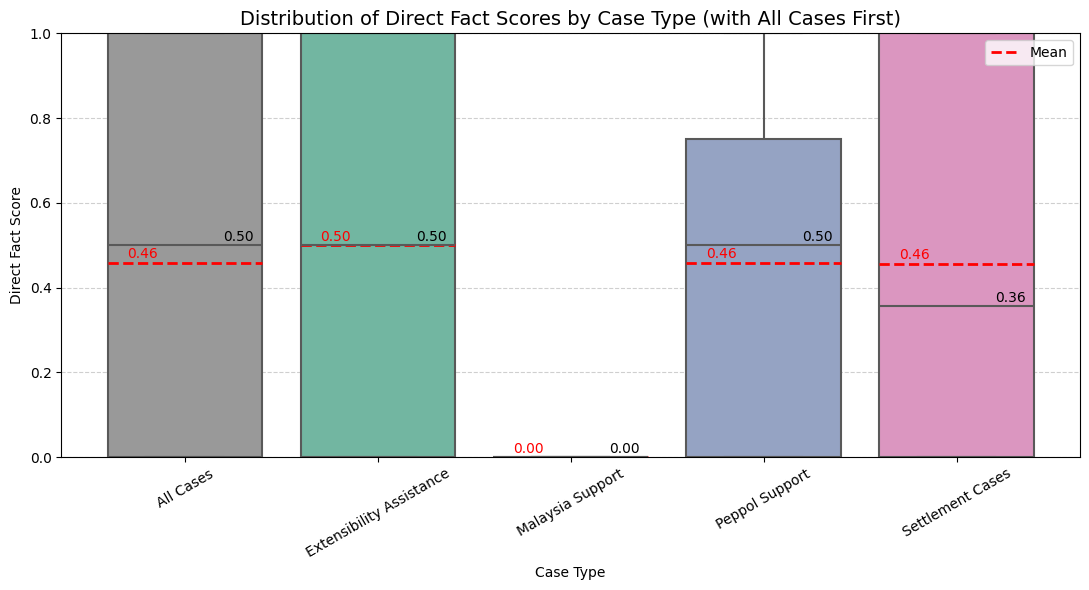

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Add "All Cases" rows
df_all = df.copy()
df_all["case_type"] = "All Cases"
df_combined = pd.concat([df, df_all], ignore_index=True)

# Define custom order (All Cases first)
case_order = [
    "All Cases",
    "Extensibility Assistance",
    "Malaysia Support",
    "Peppol Support",
    "Settlement Cases",
]

# Custom palette including All Cases
custom_palette = {
    "Extensibility Assistance": "#66c2a5",
    "Malaysia Support": "#fc8d62",
    "Peppol Support": "#8da0cb",
    "Settlement Cases": "#e78ac3",
    "All Cases": "#999999",
}

plt.figure(figsize=(11, 6))

# Boxplot with specified order
ax = sns.boxplot(
    data=df_combined,
    x="case_type",
    y="fact_score.direct_fact_score",
    order=case_order,
    palette=custom_palette,
    linewidth=1.5,
    showfliers=False,
    whis=[0, 100],
)

# Compute mean and median
grouped = df_combined.groupby("case_type")["fact_score.direct_fact_score"]
medians = grouped.median()
means = grouped.mean()

# Add lines and labels
for x, case_type in enumerate(case_order):
    median = medians[case_type]
    mean = means[case_type]

    # Mean (red dashed)
    ax.hlines(
        mean,
        x - 0.4,
        x + 0.4,
        colors="red",
        linestyles="--",
        linewidth=2,
        label="Mean" if x == 0 else "",
    )

    # Labels
    ax.text(
        x + 0.2, median + 0.02, f"{median:.2f}", color="black", va="center", fontsize=10
    )
    ax.text(x - 0.3, mean + 0.02, f"{mean:.2f}", color="red", va="center", fontsize=10)

# Plot settings
plt.title(
    "Distribution of Direct Fact Scores by Case Type (with All Cases First)",
    fontsize=14,
)
plt.xlabel("Case Type")
plt.ylabel("Direct Fact Score")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

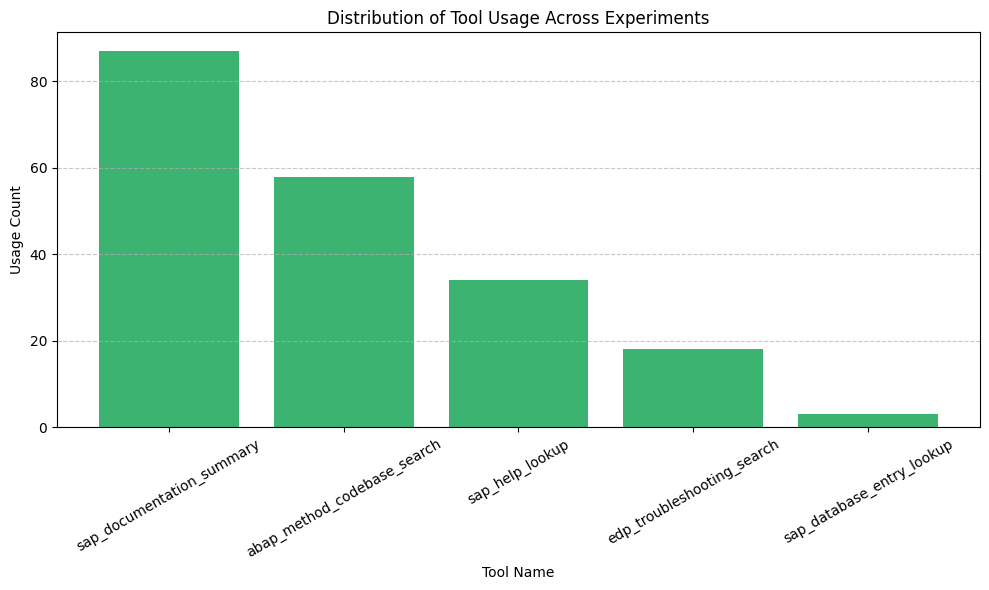

In [6]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# Initialize counter
tool_counts = Counter()

# Loop through each list of tools
for tools_list in df["tools_used"]:
    if isinstance(tools_list, list):
        for tool in tools_list:
            tool_name = tool.get("tool_name")
            if tool_name:
                tool_counts[tool_name] += 1

# Convert to DataFrame
tool_df = pd.DataFrame(tool_counts.items(), columns=["Tool Name", "Usage Count"])
tool_df = tool_df.sort_values(by="Usage Count", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(tool_df["Tool Name"], tool_df["Usage Count"], color="mediumseagreen")
plt.title("Distribution of Tool Usage Across Experiments")
plt.xlabel("Tool Name")
plt.ylabel("Usage Count")
plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Stacked Distribution of Agent Outcomes by Case Type

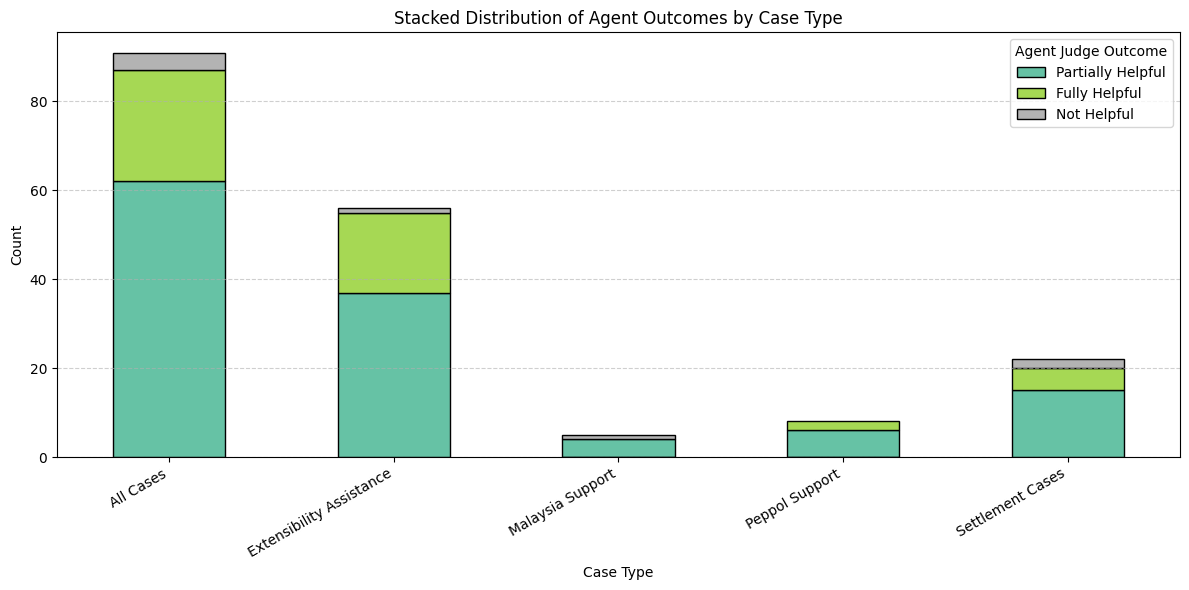

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# First, prepare the data
# Ensure 'case_type' exists and 'agent_judge_outcome' is consistent
df_casewise = (
    df.groupby(["case_type", "agent_judge_outcome"]).size().unstack(fill_value=0)
)

# Add "All Cases"
df_all = df["agent_judge_outcome"].value_counts().to_frame().T
df_all.index = ["All Cases"]

# Combine
df_combined = pd.concat([df_all, df_casewise])

# Plot
ax = df_combined.plot(
    kind="bar", stacked=True, figsize=(12, 6), colormap="Set2", edgecolor="black"
)

# Customize
plt.title("Stacked Distribution of Agent Outcomes by Case Type")
plt.xlabel("Case Type")
plt.ylabel("Count")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="Agent Judge Outcome")
plt.tight_layout()
plt.show()

# Distribution of LLM Judge Outcomes

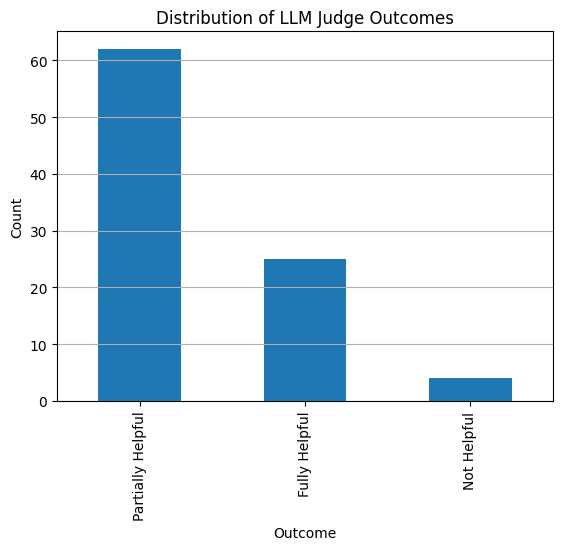

In [8]:
df["agent_judge_outcome"].value_counts().plot(kind="bar")
plt.title("Distribution of LLM Judge Outcomes")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.grid(axis="y")
plt.show()

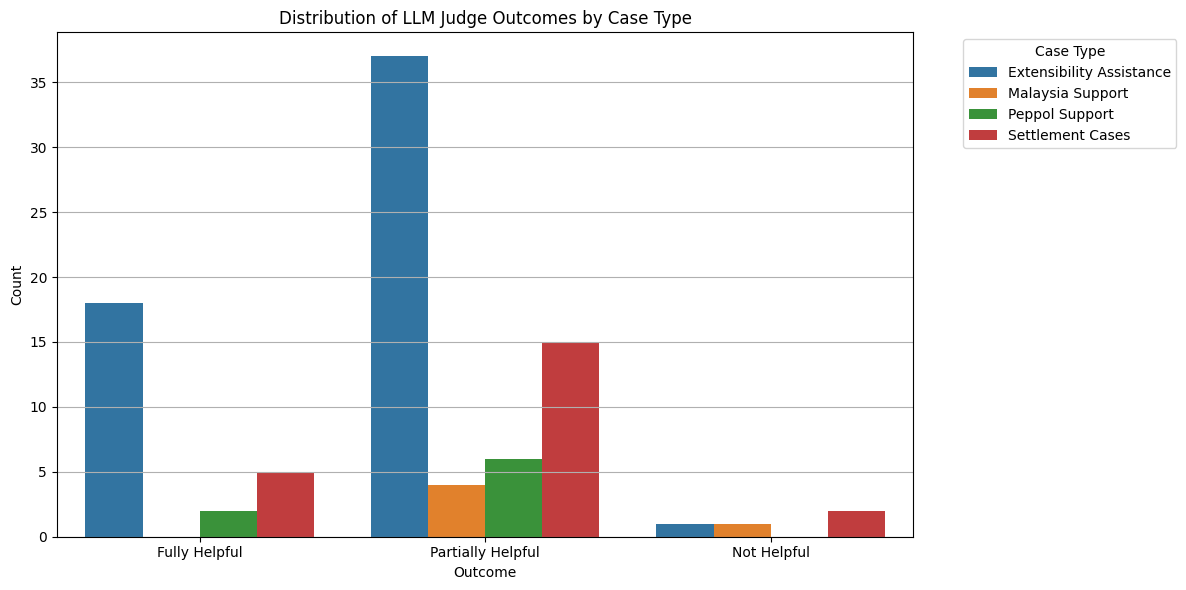

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="agent_judge_outcome", hue="case_type")
plt.title("Distribution of LLM Judge Outcomes by Case Type")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.grid(axis="y")
plt.legend(title="Case Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# BERT Score per Experiment

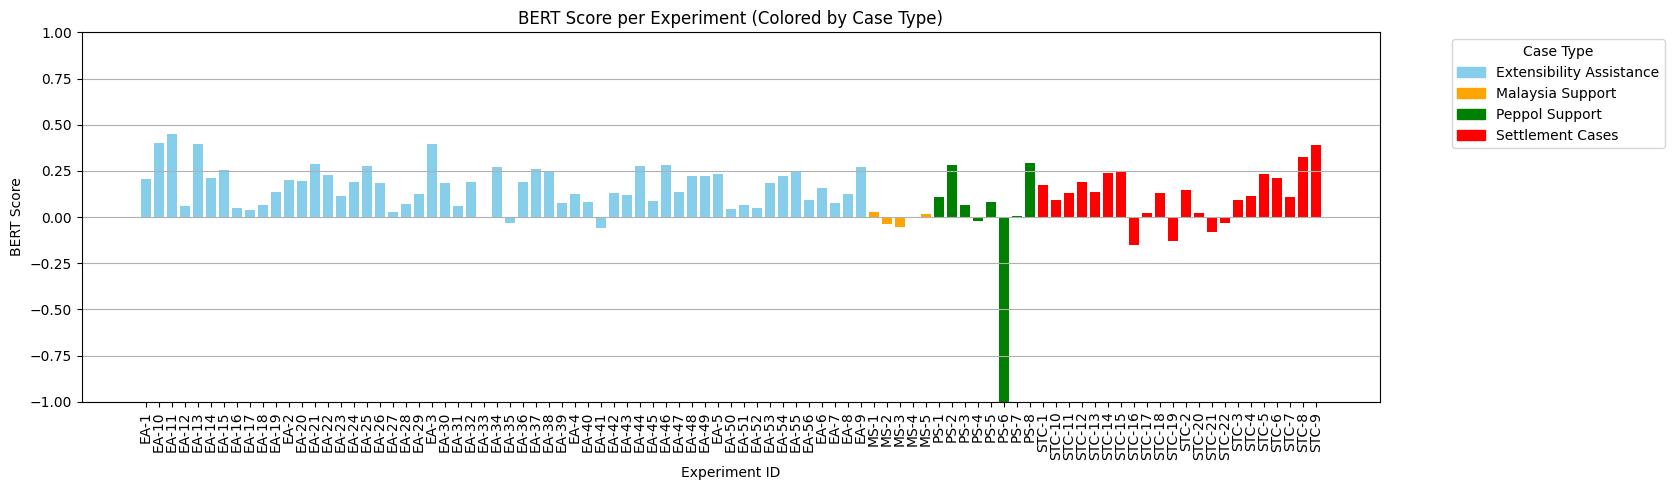

In [10]:
import matplotlib.pyplot as plt

# Define colors for each case_type
case_colors = {
    "Extensibility Assistance": "skyblue",
    "Malaysia Support": "orange",
    "Peppol Support": "green",
    "Settlement Cases": "red",
}

# Map colors to case_type
colors = df["case_type"].map(case_colors)

plt.figure(figsize=(14, 5))
plt.bar(df["id"], df["bert_score"], color=colors)
plt.xlabel("Experiment ID")
plt.ylabel("BERT Score")
plt.title("BERT Score per Experiment (Colored by Case Type)")
plt.ylim(-1, 1)
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.tight_layout()

# Create custom legend
from matplotlib.patches import Patch

legend_handles = [
    Patch(color=color, label=label) for label, color in case_colors.items()
]
plt.legend(
    handles=legend_handles,
    title="Case Type",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

plt.show()

# Fact Contained per Experiment

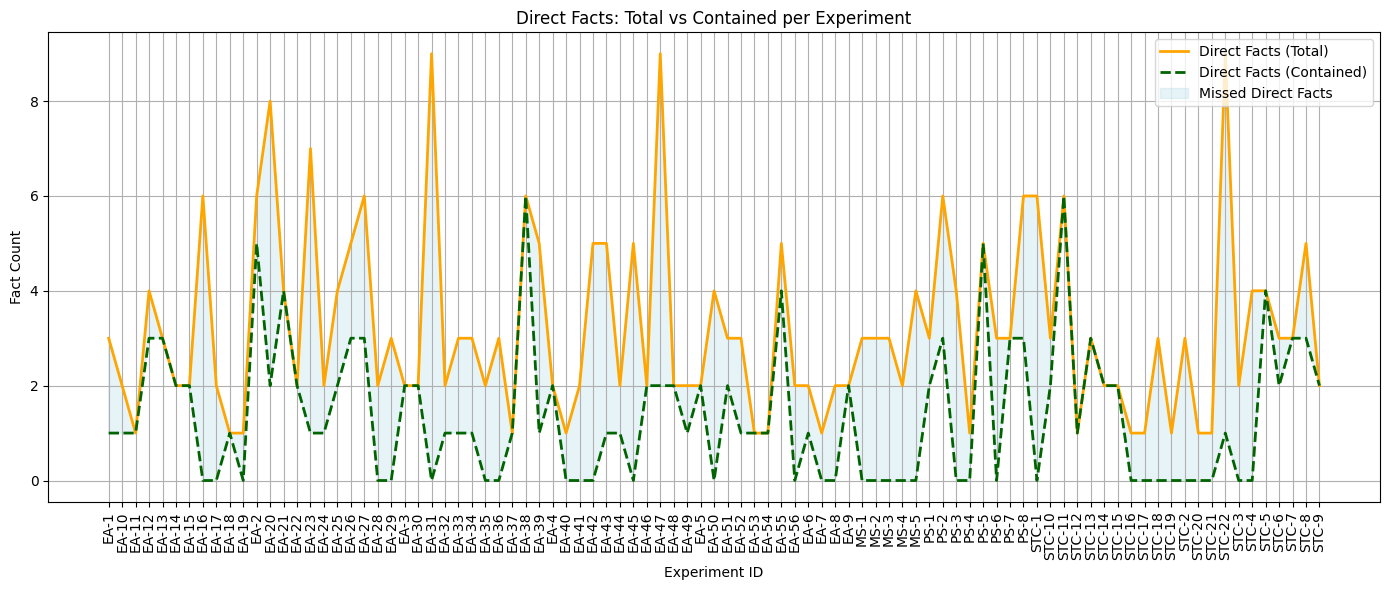

In [11]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(df))

plt.figure(figsize=(14, 6))

# Plot total and contained
plt.plot(
    x,
    df["direct_facts_total"],
    label="Direct Facts (Total)",
    color="orange",
    linewidth=2,
)
plt.plot(
    x,
    df["direct_facts_contained"],
    label="Direct Facts (Contained)",
    color="darkgreen",
    linestyle="--",
    linewidth=2,
)

# Fill area between lines
plt.fill_between(
    x,
    df["direct_facts_total"],
    df["direct_facts_contained"],
    where=(df["direct_facts_total"] > df["direct_facts_contained"]),
    interpolate=True,
    color="lightblue",
    alpha=0.3,
    label="Missed Direct Facts",
)

plt.xticks(x, df["id"], rotation=90)
plt.title("Direct Facts: Total vs Contained per Experiment")
plt.xlabel("Experiment ID")
plt.ylabel("Fact Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Time consumed for run

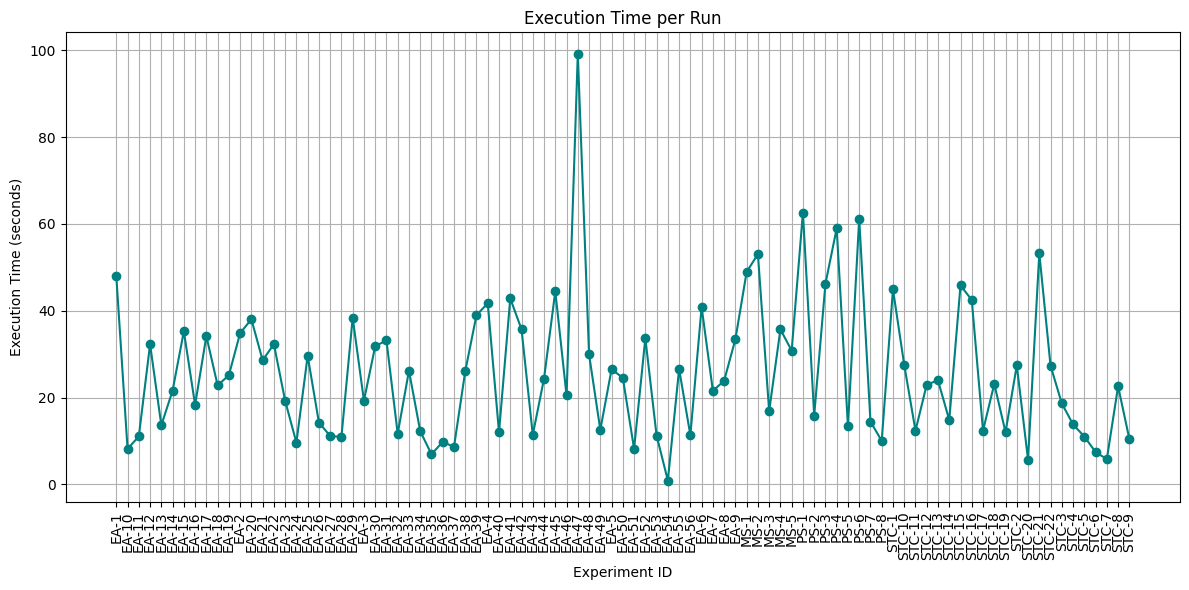

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(
    df["id"], df["excecution_time_seconds"], marker="o", linestyle="-", color="teal"
)

plt.title("Execution Time per Run")
plt.xlabel("Experiment ID")
plt.ylabel("Execution Time (seconds)")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

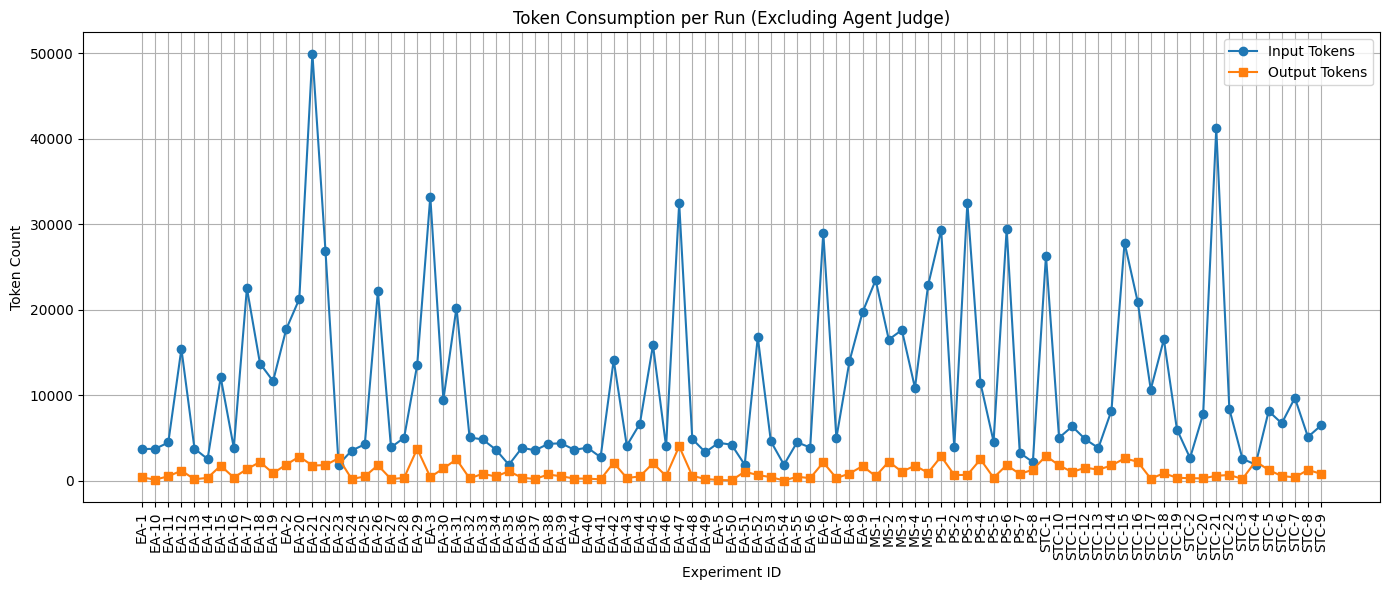

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))


# Plot input, output, and total tokens
plt.plot(
    df["id"],
    df["tokens_consumed.input_tokens"],
    label="Input Tokens",
    marker="o",
)
plt.plot(
    df["id"],
    df["tokens_consumed.output_tokens"],
    label="Output Tokens",
    marker="s",
)

plt.title("Token Consumption per Run (Excluding Agent Judge)")
plt.xlabel("Experiment ID")
plt.ylabel("Token Count")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Average Direct Fact Score by LLM Judge Outcome

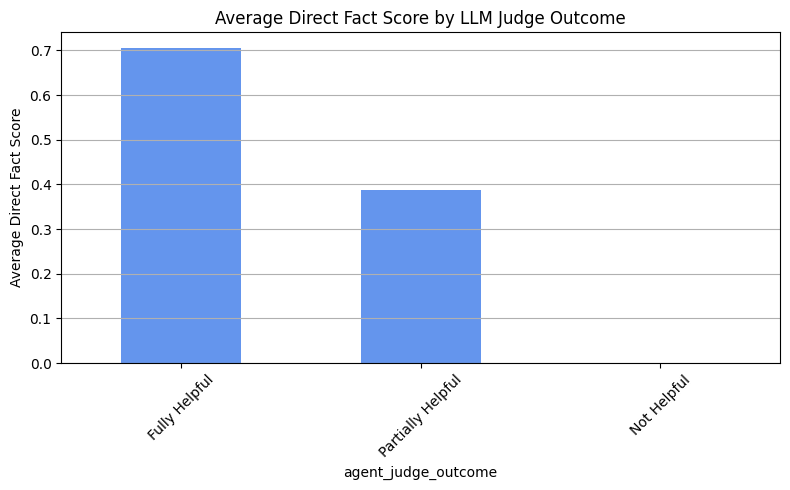

In [14]:
grouped = (
    df.groupby("agent_judge_outcome")["fact_score.direct_fact_score"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8, 5))
grouped.plot(kind="bar", color="cornflowerblue")
plt.ylabel("Average Direct Fact Score")
plt.title("Average Direct Fact Score by LLM Judge Outcome")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Average Token Consumption by Component

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_25878/2585382240.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Agent Judge": [avg_input[0], avg_output[0], avg_total[0]],
/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_25878/2585382240.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Agent": [avg_input[1], avg_output[1], avg_total[1]],


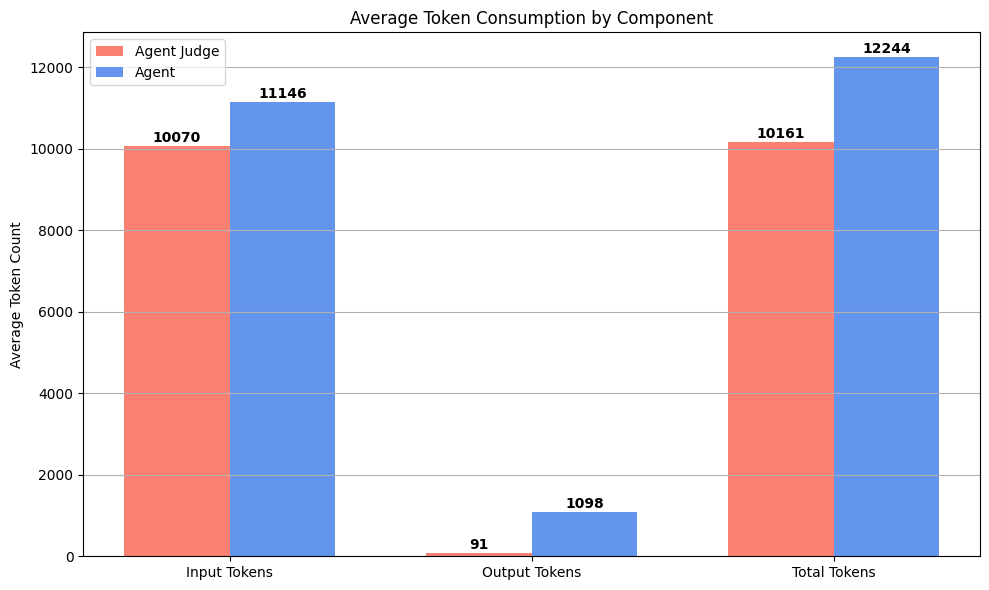

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate average tokens
avg_input = df[
    ["agent_judge_tokens_consumed.input_tokens", "tokens_consumed.input_tokens"]
].mean()
avg_output = df[
    ["agent_judge_tokens_consumed.output_tokens", "tokens_consumed.output_tokens"]
].mean()
avg_total = df[
    ["agent_judge_tokens_consumed.total_tokens", "tokens_consumed.total_tokens"]
].mean()

# Combine into a single DataFrame-like structure
avg_tokens_df = {
    "Agent Judge": [avg_input[0], avg_output[0], avg_total[0]],
    "Agent": [avg_input[1], avg_output[1], avg_total[1]],
}

labels = ["Input Tokens", "Output Tokens", "Total Tokens"]
x = np.arange(len(labels))
bar_width = 0.35

plt.figure(figsize=(10, 6))

# Bar plots
bars_judge = plt.bar(
    x - bar_width / 2,
    avg_tokens_df["Agent Judge"],
    width=bar_width,
    label="Agent Judge",
    color="salmon",
)
bars_agent = plt.bar(
    x + bar_width / 2,
    avg_tokens_df["Agent"],
    width=bar_width,
    label="Agent",
    color="cornflowerblue",
)

# Add value labels to the tallest bar of each pair
for bars in [bars_judge, bars_agent]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 20,  # vertical offset
            f"{int(height)}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

# Aesthetics
plt.xticks(x, labels)
plt.ylabel("Average Token Count")
plt.title("Average Token Consumption by Component")
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()

<class 'dict'>
{'gpt-4.1': {'input': 0.00129, 'output': 0.00494}, 'o3': {'input': 0.0061, 'output': 0.02436}, 'anthropic--claude-3.5-sonnet': {'input': 0.00204, 'output': 0.00988}, 'gemini-2.0-flash': {'input': 0.00012, 'output': 0.0004}}


/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_25878/1107176267.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Agent Judge": (avg_input[0] / 1000) * ModelPricing[judge_model]["input"]
/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_25878/1107176267.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  + (avg_output[0] / 1000) * ModelPricing[judge_model]["output"],
/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_25878/1107176267.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (c

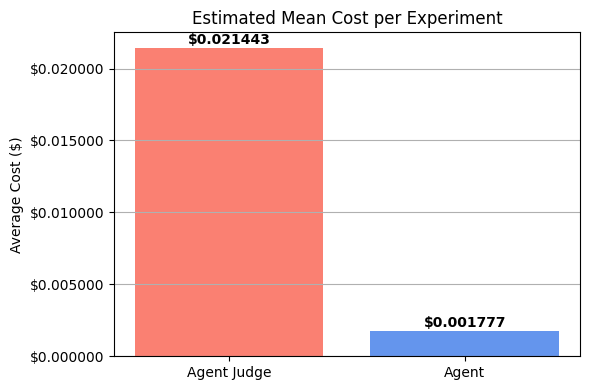

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

from experiments.interpretation.interpretation_util import ModelPricing

# Calculate average tokens (already done)
avg_input = df[
    ["agent_judge_tokens_consumed.input_tokens", "tokens_consumed.input_tokens"]
].mean()
avg_output = df[
    ["agent_judge_tokens_consumed.output_tokens", "tokens_consumed.output_tokens"]
].mean()

# Get model names from the first row
judge_model = df.loc[0, "agent_judge_model"]
agent_model = df.loc[0, "model_used"]
print(type(ModelPricing))
print(ModelPricing)
# Compute costs using dictionary keys
costs = {
    "Agent Judge": (avg_input[0] / 1000) * ModelPricing[judge_model]["input"]
    + (avg_output[0] / 1000) * ModelPricing[judge_model]["output"],
    "Agent": (avg_input[1] / 1000) * ModelPricing[agent_model]["input"]
    + (avg_output[1] / 1000) * ModelPricing[agent_model]["output"],
}

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(costs.keys(), costs.values(), color=["salmon", "cornflowerblue"])

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.00005,
        f"${height:.6f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.ylabel("Average Cost ($)")
plt.title("Estimated Mean Cost per Experiment")
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.6f}"))
plt.grid(axis="y")
plt.tight_layout()
plt.show()